David B:
> Okay.  A number of users in the past have asked for a way to search the archive for stars of a particular spectral type and rotational velocity.   So a) search the Bright Star Catalogue, setting spectral type to B*, and rotational velocity to “<20”.   This is the VizieR catalogue link:  http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=V/50&-out.max=50&-out.form=HTML%20Table&-out.add=_r&-out.add=_RAJ,_DEJ&-sort=_r&-oc.form=sexa.   If you execute a query with those constraints (increasing the number of returned rows to 200 perhaps) you see the results.  On the result page there is also a link to the TAP query page, http://tapvizier.u-strasbg.fr/adql/?%20V/50/catalog%20V/50/notes, but I haven’t used this.   Once a list of objects is found, query the CFHT ESPaDOnS archive for processed spectra of those targets.  I’m only interested in *i.fits products (intensity spectra vs. polarized spectra).   In most (likely all) cases there will be several or many spectra of an observed object.  If possible plot a spectral cutout of only one sample spectrum for each found object.  Use a wavelength range of 6675Å to 6682Å for now.  (I also haven’t tried cutouts for ESPaDOnS spectra…)

Also:
>Instead of the Bright Star catalogue you could query this VizieR table, J/A+A/393/897, in which case you wouldn’t have to constrain on spectral type, just vsini (rotational velocity).  (It’s mostly cooler A-type stars in this table.)

# Comparing Spectra


## Table of Contents
* [1. Introduction](#1.-Introduction)
* [2. Setup](#2.-Setup)
    * [2.1 Using pip](#2.1-Using-pip)
    * [2.2 From source](#2.2-From-source)
* [3. Querying](#3.-Querying)
* [4. Fetching Data](#4.-Fetching-Data)
* [5. Plotting Results](#5.-Plotting-Results)

## 1. Introduction


## 2. Setup
This tutorial will go through some of the basic functionalities of the CADC astroquery package. The CADC module can be installed in two ways:

### 2.1 Using pip
The CADC module is only available with the pre-release of the astroquery module, and can be installed using the command:

```
    pip install --pre --upgrade astroquery
```

### 2.2 From source
Alternatively, you can clone and install from the source:
```
    # If you have a github account:
    git clone git@github.com:astropy/astroquery.git
    # If you do not:
    git clone https://github.com/astropy/astroquery.git
    cd astroquery
    python setup.py install
```
Note that these commands can also be done in a Jupyter notebook by either declaring the code cell a bash cell by pasting `%%bash` at the top of the cell, or preceding each line with a `!`. More information about astroquery can be found at the [astroquery github repository](https://github.com/astropy/astroquery). 


## 3. Querying



In [37]:
from astroquery.vizier import Vizier

catalog_list = Vizier.find_catalogs('Bright Star Catalogue, 5th Revised Ed.')
print({k:v.description for k,v in catalog_list.items()})


{'V/50': 'Bright Star Catalogue, 5th Revised Ed. (Hoffleit+, 1991)'}


In [99]:
# TODO: Figure out how to extend row limit??
catalog_key = list(catalog_list.keys())[0]
catalog = Vizier.get_catalogs(catalog_key)
catalog_name = catalog.keys()[0]
result = Vizier.query_constraints(catalog=catalog_name, SpType='B*', RotVel='<20', row_limit=200)
bright_star_results = result[result.keys()[0]]
bright_star_results

HR,Name,HD,ADS,VarID,RAJ2000,DEJ2000,Vmag,B-V,SpType,NoteFlag
,,,,,"""h:m:s""","""d:m:s""",mag,mag,,
int16,bytes10,int32,bytes5,bytes9,bytes10,bytes9,float32,float32,bytes20,bytes1
39,88Gam Peg,886,,Gam Peg,00 13 14.2,+15 11 01,2.83,-0.23,B2IV,*
62,,1279,,,00 17 09.1,+47 56 51,5.89,-0.09,B7III,
153,17Zet Cas,3360,,225,00 36 58.3,+53 53 49,3.66,-0.20,B2IV,*
208,23 Cas,4382,,,00 47 46.1,+74 50 51,5.41,-0.08,B8III,*
280,Alp Scl,5737,,359,00 58 36.4,-29 21 27,4.31,-0.16,B7IIIp,*
465,,9996,,GY And,01 38 31.7,+45 24 00,6.36,0.04,B9pCrEu,*
542,45Eps Cas,11415,,652,01 54 23.7,+63 40 12,3.38,-0.15,B3III,*
562,,11905,,,01 57 56.4,+41 41 40,6.78,-0.06,B8III,*


In [73]:
#TODO: Query cadc like this instead>?

from astroquery.cadc import Cadc
from astropy.table import vstack
from astropy.coordinates import SkyCoord

# Instantiate cadc module
cadc = Cadc()

# Get target name, redshift, ra, and dec
name_list = bright_star_results['Name'].values
redshift_list = qso_data['redshift'].values
ra_list = qso_data['RA'].values
dec_list = qso_data['DEC'].values

# Build a list of skycoords from target ra and dec
coords_list = [
    SkyCoord(ra, dec, frame='icrs', unit='deg')
    for ra, dec in zip(ra_list, dec_list)
]

# Iterate through target coords and run query on each
results_list = []
for name, coords, redshift in zip(name_list, coords_list, redshift_list):
    results = cadc.query_region(coords, radius=0.01, collection='CFHTMEGAPIPE')
    if len(results):
        # We add target coordinates as columns to results to make cutout process easier
        results['qso_name'] = name
        results['qso_ra'] = coords.ra
        results['qso_dec'] = coords.dec
        results['qso_redshift'] = redshift
        results_list.append(results)

# Then vertically combine all the results into one table
results = vstack(results_list)

print('Number of results pre-reduction: {}'.format(len(results)))

In [228]:
#TODO upload resource???

# from astroquery.cadc import Cadc
# cadc = Cadc()

# upload_resource = "asu.tsv"

# j = cadc.run_query("SELECT * FROM tap_upload.test_table_upload", 'sync', \
#                     upload_resource=upload_resource, upload_table_name="test_table_upload")
# print(j.get_results())

In [240]:
import datetime
today = datetime.datetime.now().strftime("%Y-%m-%d %X")
today

'2019-06-28 16:27:17'

In [242]:
energy_bounds_ang = (6675, 6682)
ang_to_m = lambda x: x*1e-10
today = datetime.datetime.now().strftime("%Y-%m-%d %X")
hd_list = ' OR Observation.target_name LIKE '.join("'HD%"+str(hd)+"%'" for hd in bright_star_results['HD'])

query_params = {'collection': 'CFHT', 'instrument_name': 'ESPaDOnS', 'prod_id': '%i',
               'wavelength_lower': ang_to_m(energy_bounds_ang[0]),
               'wavelength_upper': ang_to_m(energy_bounds_ang[1]),
               'target_name': hd_list, 'data_release': today}

query = '''SELECT * FROM caom2.Plane AS Plane 
JOIN caom2.Observation AS Observation ON Plane.obsID = Observation.obsID 
WHERE  ( Observation.instrument_name = '{instrument_name}'
AND Observation.collection = '{collection}' 
AND Plane.productID LIKE '{prod_id}' 
AND INTERSECTS( INTERVAL( {wavelength_lower},
{wavelength_upper} ),
Plane.energy_bounds_samples ) = 1 
AND  (Observation.target_name LIKE {target_name}) 
AND Plane.dataRelease <= '{data_release}'
AND  ( Plane.quality_flag IS NULL OR Plane.quality_flag != 'junk' ) )'''.format(**query_params)

job = cadc.run_query(query, 'sync')
espadons_results = job.get_results()

In [243]:
espadons_results.show_in_notebook()

idx,caomPlaneURI,caomPublisherID,calibrationLevel,provenance_keywords,provenance_inputs,metrics_sourceNumberDensity,metrics_background,metrics_backgroundStddev,metrics_fluxDensityLimit,metrics_magLimit,position_bounds,position_bounds_samples,position_bounds_size,position_resolution,position_sampleSize,position_dimension_naxis1,position_dimension_naxis2,obsID,planeID,productID,metaRelease,dataRelease,dataProductType,provenance_name,provenance_version,provenance_reference,provenance_producer,provenance_project,provenance_runID,provenance_lastExecuted,quality_flag,position_timeDependent,position_bounds_points,energy_bounds_samples,energy_bounds_lower,energy_bounds_upper,energy_bounds_width,energy_bounds_integrated,energy_dimension,energy_resolvingPower,energy_sampleSize,energy_freqWidth,energy_freqSampleSize,energy_restwav,time_bounds_samples,time_bounds_lower,time_bounds_upper,time_bounds_width,time_bounds_integrated,time_dimension,time_resolution,time_sampleSize,time_exposure,polarization_dimension,metaChecksum,accMetaChecksum,energy_emBand,energy_bounds [2],energy_bandpassName,energy_transition_species,energy_transition_transition,time_bounds [2],polarization_states,lastModified,caomObservationURI,sequenceNumber,proposal_keywords,target_standard,target_redshift,target_moving,target_keywords,targetPosition_equinox,targetPosition_coordinates_cval1,targetPosition_coordinates_cval2,telescope_geoLocationX,telescope_geoLocationY,telescope_geoLocationZ,telescope_keywords,instrument_keywords,environment_seeing,environment_humidity,environment_elevation,environment_tau,environment_wavelengthTau,environment_ambientTemp,environment_photometric,members,typeCode,metaChecksum_2,obsID_2,accMetaChecksum_2,collection,observationID,algorithm_name,type,intent,metaRelease_2,proposal_id,proposal_pi,proposal_project,proposal_title,target_name,target_type,targetPosition_coordsys,telescope_name,requirements_flag,instrument_name,lastModified_2,maxLastModified
,,,,,,1 / deg2,Jy / pix,Jy / pix,Jy,,deg,deg,deg,arcsec,arcsec,,,,,,,,,,,,,,,,,,deg,m,m,m,m,m,,,m,Hz,Hz,m,m,d,d,d,d,,d,d,s,,,,,m,,,,d,,,,,,,,,,,deg,deg,,,,,,arcsec,,deg,,m,C,,,,,,,,,,,,,,,,,,,,,,,,
0,caom:CFHT/1845674/1845674i,ivo://cadc.nrc.ca/CFHT?1845674/1845674i,2,reduction=Intensity,caom:CFHT/1845674/1845674o,--,--,--,--,--,[130.08045907323543 -40.2636389996357 130.08104092676413 -40.2636389996357 130.0810409286738 -40.26408299963571 130.08045907132635 -40.26408299963571],[130.08104092867376 -40.26408299963571 2.0 130.08045907132623 -40.26408299963571 1.0 130.08045907323572 -40.26363899963572 1.0 130.08104092676427 -40.26363899963572 1.0 0.0 0.0 0.0],0.000627910821697447,--,1.5984,1,1,00000000-0000-0000-adda-0150d2e4f0b1,00000000-0000-0000-2f25-0152ee94a9ab,1845674i,2015-11-04T07:08:38.000,2017-02-28T00:00:00.000,spectrum,UPENA,1.0,http://www.cfht.hawaii.edu/Instruments/Upena/,CFHT,STANDARD PIPELINE,,2015-11-04T07:08:38.000,,--,[130.08045907323572 -40.26363899963573 130.08104092676427 -40.26363899963573 130.08104092867376 -40.26408299963572 130.08045907132623 -40.26408299963572],[[3.69392089844e-07 1.0482266845700002e-06]],3.69392089844e-07,1.0482266845700002e-06,6.788345947260003e-07,--,213721,65000.0,3.1762652931906563e-12,525583748443030.6,1895302833.0625,--,[[57330.5945119 57330.5950906037]],57330.5945119,57330.5950906037,0.0005787037007394247,--,1,50.0,0.0005787037007394247,50.0,--,md5:bff1fa8e271da1e96d2dc30100bc3d81,md5:cf175e5a02ad779a9abae1276c34eefc,Optical,3.69392089844e-07 .. 1.0482266845700002e-06,,,,57330.5945119 .. 57330.5950906037,,2017-11-10T11:19:36.203,caom:CFHT/1845674,1845674,,0,--,0,,--,--,--,-5464228.6,-2493778.2,2150937.8,,"Polarimetry, R=65,000",--,6.08,--,--,--,1.84,0,,S,md5:b841d242949649fcdcc341754c254e06,00000000-0000-0000-adda-0150d2e4f0b1,md5:e62864059068d15d64743fd7cd28b801,CFHT,1845674,exposure,OBJECT,science,2015-11-04T07:08:38.000,15BC18,James Sikora,,"A complete characterization of the physical, magnetic, and rotational properties of magnetic intermediate-

In [244]:
# Want one one spectra per target name!
from astropy.table import unique
unqiue_by_target = unique(espadons_results, keys='target_name')
unqiue_by_target.show_in_notebook()

idx,caomPlaneURI,caomPublisherID,calibrationLevel,provenance_keywords,provenance_inputs,metrics_sourceNumberDensity,metrics_background,metrics_backgroundStddev,metrics_fluxDensityLimit,metrics_magLimit,position_bounds,position_bounds_samples,position_bounds_size,position_resolution,position_sampleSize,position_dimension_naxis1,position_dimension_naxis2,obsID,planeID,productID,metaRelease,dataRelease,dataProductType,provenance_name,provenance_version,provenance_reference,provenance_producer,provenance_project,provenance_runID,provenance_lastExecuted,quality_flag,position_timeDependent,position_bounds_points,energy_bounds_samples,energy_bounds_lower,energy_bounds_upper,energy_bounds_width,energy_bounds_integrated,energy_dimension,energy_resolvingPower,energy_sampleSize,energy_freqWidth,energy_freqSampleSize,energy_restwav,time_bounds_samples,time_bounds_lower,time_bounds_upper,time_bounds_width,time_bounds_integrated,time_dimension,time_resolution,time_sampleSize,time_exposure,polarization_dimension,metaChecksum,accMetaChecksum,energy_emBand,energy_bounds [2],energy_bandpassName,energy_transition_species,energy_transition_transition,time_bounds [2],polarization_states,lastModified,caomObservationURI,sequenceNumber,proposal_keywords,target_standard,target_redshift,target_moving,target_keywords,targetPosition_equinox,targetPosition_coordinates_cval1,targetPosition_coordinates_cval2,telescope_geoLocationX,telescope_geoLocationY,telescope_geoLocationZ,telescope_keywords,instrument_keywords,environment_seeing,environment_humidity,environment_elevation,environment_tau,environment_wavelengthTau,environment_ambientTemp,environment_photometric,members,typeCode,metaChecksum_2,obsID_2,accMetaChecksum_2,collection,observationID,algorithm_name,type,intent,metaRelease_2,proposal_id,proposal_pi,proposal_project,proposal_title,target_name,target_type,targetPosition_coordsys,telescope_name,requirements_flag,instrument_name,lastModified_2,maxLastModified
,,,,,,1 / deg2,Jy / pix,Jy / pix,Jy,,deg,deg,deg,arcsec,arcsec,,,,,,,,,,,,,,,,,,deg,m,m,m,m,m,,,m,Hz,Hz,m,m,d,d,d,d,,d,d,s,,,,,m,,,,d,,,,,,,,,,,deg,deg,,,,,,arcsec,,deg,,m,C,,,,,,,,,,,,,,,,,,,,,,,,
0,caom:CFHT/1168490/1168490i,ivo://cadc.nrc.ca/CFHT?1168490/1168490i,2,reduction=Intensity,caom:CFHT/1168490/1168490o,--,--,--,--,--,[28.59933351599855 63.66988899913083 28.598332484001457 63.66988899913083 28.598332476163797 63.6703329991309 28.599333523836208 63.6703329991309],[28.59833248400137 63.669888999130954 2.0 28.599333515998627 63.669888999130954 1.0 28.5993335238362 63.67033299913092 1.0 28.598332476163797 63.67033299913092 1.0 0.0 0.0 0.0],0.0006279108216879551,--,1.5984,1,1,00000000-0000-0000-3141-0140871ce6d3,00000000-0000-0000-c730-0140871d0902,1168490i,2010-02-23T07:21:21.000,2011-08-31T00:00:00.000,spectrum,UPENA,1.0,http://www.cfht.hawaii.edu/Instruments/Upena/,CFHT,STANDARD PIPELINE,,2010-02-23T07:21:21.000,,--,[28.59933351599856 63.66988899913096 28.598332484001435 63.669888999130926 28.598332476163797 63.670332999130906 28.599333523836197 63.670332999130935],[[3.69754608154e-07 1.04804418945e-06]],3.69754608154e-07,1.04804418945e-06,6.78289581296e-07,--,213541,65000.0,3.176390394800062e-12,524738247236335.4,1894896186.5,--,[[55250.2316002 55250.231947422224]],55250.2316002,55250.231947422224,0.00034722222335403785,--,1,30.0,0.00034722222335403785,30.0,--,md5:65734293715d9a5edcf5e20ca2c201ad,md5:835c08e1ec3a3960b92b3e55b3a86648,Optical,3.69754608154e-07 .. 1.04804418945e-06,,,,55250.2316002 .. 55250.231947422224,,2017-06-26T03:04:31.773,caom:CFHT/1168490,1168490,,0,--,0,,--,--,--,-5464228.6,-2493778.2,2150937.8,,"Polarimetry, R=65,000",--,6.54,--,--,--,5.56,0,,S,md5:4cae76e47cd78c2196783ca28d31678c,00000000-0000-0000-3141-0140871ce6d3,md5:b5d883e9d7fd4088c7d0bd483d86c170,CFHT,1168490,exposure,OBJECT,science,2010-02-23T07:21:21.000,10AP14,Gregg Wade,MIMES,MiMeS,HD 11415,,,CFHT 3.6m,,ESPaDOnS,2017-11-13T06:37:22.767,2017-11-13T06:37:22.767
1,caom:CFHT/794061/794061i,ivo://cadc.nrc.ca

In [224]:
urls = cadc.get_data_urls(unqiue_by_target)
urls

['https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/1168490i.fits.gz?RUNID=wd61efexvzsv8mpf',
 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/794061i.fits.gz?RUNID=pkxvcgm3wvf4u8vy',
 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/1700127i.fits.gz?RUNID=w5bvdah7cu2d48kz',
 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/781666i.fits.gz?RUNID=pdxsiphnqc53evvq',
 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/1266587i.fits.gz?RUNID=r1zi25iw76b78x6v',
 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/1887188i.fits.gz?RUNID=dfvkbhf211t0kae0',
 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/1685462i.fits.gz?RUNID=u07ezbisbrl2knwr',
 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/1284182i.fits.gz?RUNID=b7ykqh6wrlxub8w9',
 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/1940335i.fits.gz?RUNID=jkf7r13nidb5viko',
 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/1845674i.fits.

In [225]:
from astropy.io import fits
url = urls[0]
target_list = unqiue_by_target['target_name']
data_list = []

for url in urls[0:12]:
    with fits.open(url) as hdulist:
        hdulist.info()
        data = hdulist[0].data
        data_list.append(data)

Filename: /home/badune/.astropy/cache/download/py3/c6a308eba447e6bb9c0f5dea3f594d86
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     503   (213542, 12)   float32   
Filename: /home/badune/.astropy/cache/download/py3/d3dbfcc885d7b1c15ae99b8ebc157f8e
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     470   (213650, 12)   float32   
Filename: /home/badune/.astropy/cache/download/py3/824f885d6330354c80665eae0ca97058
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     542   (213831, 12)   float32   
Filename: /home/badune/.astropy/cache/download/py3/c90c3fb0626fde7d6ab168c3755c05a9
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     466   (213831, 12)   float32   
Filename: /home/badune/.astropy/cache/download/py3/14d3c1ccf28a1931c73fbd0877dfe1f1
No.    Name      Ver    Type      Cards   Dimensions   Forma

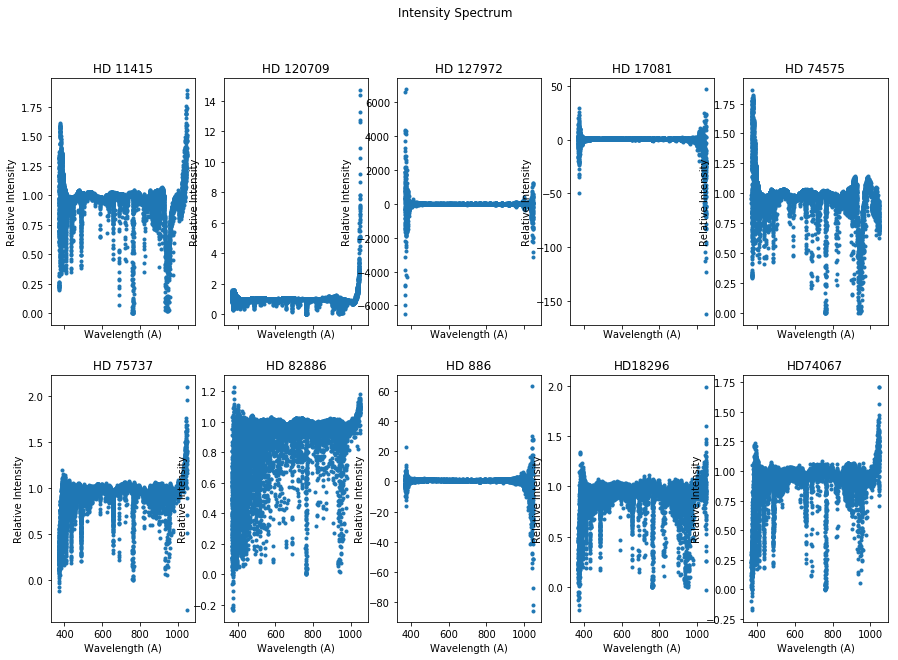

In [227]:
import matplotlib.pyplot as plt
import numpy as np
import math

cols = 5
rows = math.ceil(len(data_list)/cols)
fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, squeeze=True)
for data, target_name, ax in zip(data_list, target_list, axes.flatten()):
    ax.scatter(data[0][::15], data[1][::15], marker='.')
    ax.set_title(target_name)
    ax.set_xlabel('Wavelength (A)')
    ax.set_ylabel('Relative Intensity')
fig.suptitle('Intensity Spectrum')
plt.show()

In [ ]:
# COL1    = 'Wavelength'         / Normalized                                     
# COL2    = 'Intensity'          / Normalized                                     
# COL3    = 'ErrorBar'           / Normalized                                     
# COL4    = 'Wavelength'         / UnNormalized                                   
# COL5    = 'Intensity'          / UnNormalized                                   
# COL6    = 'ErrorBar'           / UnNormalized                                   
# COL7    = 'Wavelength'         / Normalized, no autowave correction             
# COL8    = 'Intensity'          / Normalized, no autowave correction             
# COL9    = 'ErrorBar'           / Normalized, no autowave correction             
# COL10   = 'Wavelength'         / UnNormalized, no autowave correction           
# COL11   = 'Intensity'          / UnNormalized, no autowave correction           
# COL12   = 'ErrorBar'           / UnNormalized, no autowave correction    